# Introduction

This work presents a constrained combinatorial optimization approach to the **Sports League Assignment Problem** using **Genetic Algorithms (GAs)**. The objective is to allocate a fixed pool of professional players into a set of 5 structurally valid teams in such a way that the **standard deviation of the teams' average skill ratings** is minimized—promoting competitive balance across the league.

Each player is defined by three attributes: **position** (one of `GK`, `DEF`, `MID`, `FWD`), **skill rating** (a numerical measure of ability), and **cost** (in million euros). A valid solution must satisfy the following **hard constraints**:

- Each team must consist of exactly **7 players**, with a specific positional structure: **1 GK, 2 DEF, 2 MID, and 2 FWD**
- Each team must have a **total cost ≤ 750 million €**
- Each player must be assigned to **exactly one team** (no overlaps)

The **search space** is therefore highly constrained and discrete, and infeasible configurations are explicitly excluded from the solution space. The optimization objective is to identify league configurations where teams are not only valid but also **skill-balanced**, quantified by the **standard deviation of average skill ratings across teams**, which serves as the **fitness function** (to be minimized).

To address this, we implement a domain-adapted **Genetic Algorithm framework** featuring:

- A custom **representation** based on team-to-player mappings
- Validity-preserving **mutation** and **crossover** operators
- Multiple **selection mechanisms**
- Optional **elitism** and population-level diversity handling

This report provides a formal problem definition, details the design of the solution encoding and operators, and presents empirical results comparing different GA configurations. The overall objective is to evaluate how well GA-based metaheuristics can navigate this complex constrained search space and evolve solutions that both satisfy domain constraints and optimize league balance.

In addition to Genetic Algorithms, this project also explores and evaluates alternative optimization strategies, such as **Hill Climbing** and **Simulated Annealing**, which are well-suited for navigating discrete and constrained search spaces. These algorithms offer different trade-offs in terms of exploration, exploitation, and convergence speed. By implementing and benchmarking multiple approaches on the same problem, we aim to gain deeper insights into their relative effectiveness and robustness when applied to complex constrained optimization tasks such as the Sports League Assignment. This comparative analysis enhances the interpretability of results and supports a broader understanding of the strengths and limitations of population-based versus local search-based heuristics.


## Representation

### A. Team-based Representation (Structured Encoding)

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{t_1, t_2, \dots, t_5\}$ be the set of teams

Define the assignment function:

$$
A: P \rightarrow T
$$

such that each player is assigned to exactly one team, and the following constraints are satisfied:

**Team Size:**

$$
\forall t_j \in T,\quad \left|\{p_i \in P \mid A(p_i) = t_j\}\right| = 7
$$

**Positional Requirements:** For each team $t_j \in T$:

$$
\begin{aligned}
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{GK}\}| = 1 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{DEF}\}| = 2 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{MID}\}| = 2 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{FWD}\}| = 2
\end{aligned}
$$

**Budget Constraint:**

$$
\forall t_j \in T,\quad \sum_{p_i \in P \mid A(p_i) = t_j} cost(p_i) \leq 750
$$

**Objective Function:** Minimize the standard deviation of average team skill:

$$
f(A) = \sigma\left(\left\{\frac{1}{7} \sum_{p_i \in P \mid A(p_i) = t_j} skill(p_i) \,\middle|\, t_j \in T\right\}\right)
$$


### B. Player-assignment Representation (Linear Encoding)

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{0, 1, 2, 3, 4\}$ be team IDs

A solution is represented by a vector:

$$
\mathbf{a} = [a_1, a_2, \dots, a_{35}] \in T^{35}
$$

where $a_i$ is the team assignment for player $p_i$.

**Team Definitions:**

$$
P_j = \{p_i \in P \mid a_i = j\}, \quad \forall j \in T
$$

**Constraints:**

$$
|P_j| = 7 \quad \text{and}
$$

$$
\begin{aligned}
&|\{p \in P_j \mid pos(p) = \text{GK}\}| = 1 \\
&|\{p \in P_j \mid pos(p) = \text{DEF}\}| = 2 \\
&|\{p \in P_j \mid pos(p) = \text{MID}\}| = 2 \\
&|\{p \in P_j \mid pos(p) = \text{FWD}\}| = 2 \\
&\sum_{p \in P_j} cost(p) \leq 750
\end{aligned}
$$

**Objective Function:**

$$
f(\mathbf{a}) = \sigma\left(\left\{\frac{1}{7} \sum_{p \in P_j} skill(p) \,\middle|\, j \in T\right\}\right)
$$

## Genetic Algorithm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from solution import LeagueSolution, LeagueHillClimbingSolution
from evolution import genetic_algorithm, hill_climbing
from operators import (
    mutate_swap,
    mutate_team_shift,
    mutate_shuffle_team,
    crossover_one_point,
    crossover_uniform,
    selection_tournament,
    selection_ranking
)

In [2]:
#loading csv and turning it to a line dictionary

players = pd.read_csv("sports players.csv", sep=";").to_dict(orient="records")
players

[{'Name': 'Alex Carter', 'Position': 'GK', 'Skill': 85, 'Salary': 90},
 {'Name': 'Jordan Smith', 'Position': 'GK', 'Skill': 88, 'Salary': 100},
 {'Name': 'Ryan Mitchell', 'Position': 'GK', 'Skill': 83, 'Salary': 85},
 {'Name': 'Chris Thompson', 'Position': 'GK', 'Skill': 80, 'Salary': 80},
 {'Name': 'Blake Henderson', 'Position': 'GK', 'Skill': 87, 'Salary': 95},
 {'Name': 'Daniel Foster', 'Position': 'DEF', 'Skill': 90, 'Salary': 110},
 {'Name': 'Lucas Bennett', 'Position': 'DEF', 'Skill': 85, 'Salary': 90},
 {'Name': 'Owen Parker', 'Position': 'DEF', 'Skill': 88, 'Salary': 100},
 {'Name': 'Ethan Howard', 'Position': 'DEF', 'Skill': 80, 'Salary': 70},
 {'Name': 'Mason Reed', 'Position': 'DEF', 'Skill': 82, 'Salary': 75},
 {'Name': 'Logan Brooks', 'Position': 'DEF', 'Skill': 86, 'Salary': 95},
 {'Name': 'Caleb Fisher', 'Position': 'DEF', 'Skill': 84, 'Salary': 85},
 {'Name': 'Nathan Wright', 'Position': 'MID', 'Skill': 92, 'Salary': 120},
 {'Name': 'Connor Hayes', 'Position': 'MID', 'S

In [3]:
# Test configurations (3 mutations, 2 crossovers, 2 selections)
configs = [
    (mutate_swap, crossover_one_point, selection_tournament),
    (mutate_team_shift, crossover_uniform, selection_ranking),
    (mutate_shuffle_team, crossover_uniform, selection_tournament),
    (mutate_swap, crossover_uniform, selection_ranking)
]

results = []
best_solutions = []

In [4]:
#Running GA for each combination config
for i, (m_op, c_op, s_op) in enumerate(configs):
    start = time.time()
    print(f"Config {i+1} running ...")
    best, history = genetic_algorithm(
        players=players,
        mutation_operator=m_op,
        crossover_operator=c_op,
        selection_operator=s_op,
        generations=30
        #generations=10
    )
    results.append((f"Config {i+1}", history))
    best_solutions.append((f"Config {i+1}", best, best.fitness(players)))
    print("-------------- Processing time: ", time.time() - start)

Config 1 running ...
-------------- Processing time:  6.950977087020874
Config 2 running ...
-------------- Processing time:  25.18385601043701
Config 3 running ...
-------------- Processing time:  8.034725904464722
Config 4 running ...
-------------- Processing time:  21.715409994125366


The standard deviation is related to optimization ability because it quantifies the dispersion or variability of a data set in relation to its mean. In optimization contexts, understanding variability can be crucial to identify the efficiency and accuracy of a process or model.

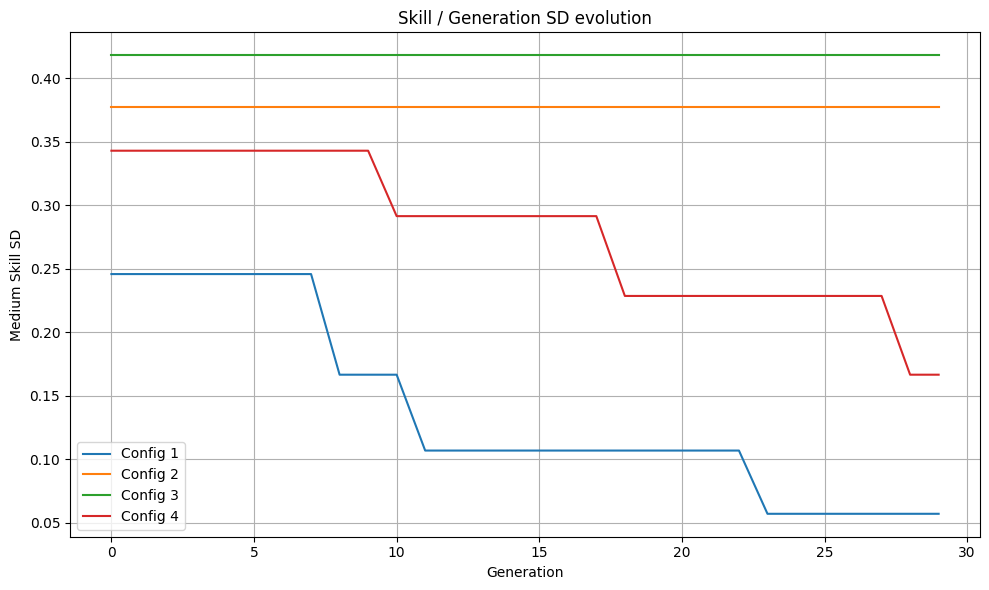

In [6]:
# Fitness evolution plot
plt.figure(figsize=(10, 6))
for label, hist in results:
    plt.plot(hist, label=label)
plt.title("Skill / Generation SD evolution")
plt.xlabel("Generation")
plt.ylabel("Medium Skill SD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

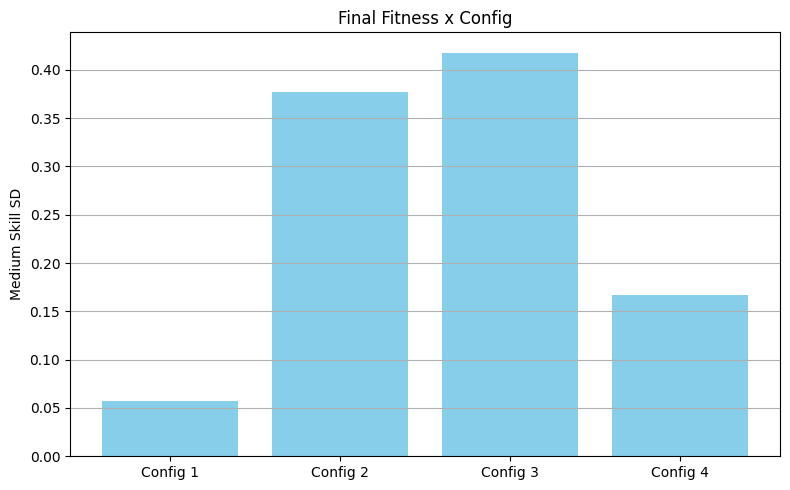

In [7]:
# Fitness configuration
labels = [label for label, _, _ in best_solutions]
fitness_values = [fit for _, _, fit in best_solutions]

plt.figure(figsize=(8, 5))
plt.bar(labels, fitness_values, color='skyblue')
plt.title("Final Fitness x Config")
plt.ylabel("Medium Skill SD")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Exibir composição de times da melhor solução encontrada
better = min(best_solutions, key=lambda x: x[2])
print(f"Best Config: {better[0]} | Fitness: {better[2]:.4f}")
teams = [[] for _ in range(5)]
for idx, team_id in enumerate(better[1].assignment):
    player = players[idx]
    teams[team_id].append((player["Name"], player["Position"], player["Skill"], player["Salary"]))

for i, team in enumerate(teams):
    print(f"\nTime {i+1}:")
    for p in team:
        print(f"  {p[0]:20s} | {p[1]:3s} | Skill: {p[2]} | Salary: €{p[3]}M")

Best Config: Config 1 | Fitness: 0.0571

Time 1:
  Alex Carter          | GK  | Skill: 85 | Salary: €90M
  Daniel Foster        | DEF | Skill: 90 | Salary: €110M
  Mason Reed           | DEF | Skill: 82 | Salary: €75M
  Connor Hayes         | MID | Skill: 89 | Salary: €105M
  Spencer Ward         | MID | Skill: 84 | Salary: €85M
  Sebastian Perry      | FWD | Skill: 95 | Salary: €150M
  Tyler Jenkins        | FWD | Skill: 80 | Salary: €70M

Time 2:
  Blake Henderson      | GK  | Skill: 87 | Salary: €95M
  Nathan Wright        | MID | Skill: 92 | Salary: €120M
  Chase Murphy         | FWD | Skill: 86 | Salary: €95M
  Bentley Rivera       | MID | Skill: 88 | Salary: €100M
  Jaxon Griffin        | DEF | Skill: 79 | Salary: €65M
  Brayden Hughes       | DEF | Skill: 87 | Salary: €100M
  Zachary Nelson       | FWD | Skill: 86 | Salary: €92M

Time 3:
  Jordan Smith         | GK  | Skill: 88 | Salary: €100M
  Logan Brooks         | DEF | Skill: 86 | Salary: €95M
  Austin Torres        | MID |

## Run Hill climbing and tract history

In [10]:
# Run Hill Climbing
print("Running Hill Climbing...")
hc_solution, hc_history, hc_fitness = hill_climbing(players, verbose=True)

# Append Hill Climbing results for plotting
results.append(("Hill Climbing", hc_history))
best_solutions.append(("Hill Climbing", hc_solution, hc_fitness))
print("Hill Climbing Fitness:", hc_fitness)

Running Hill Climbing...
Iteration 0: fitness = 0.5375682206350489
Iteration 1: fitness = 0.20995626366712705
Iteration 2: fitness = 0.10690449676496672
Iteration 3: fitness = 0.05714285714285552
Hill Climbing Fitness: [0.9705878715121717, 0.5375682206350489, 0.20995626366712705, 0.10690449676496672, 0.05714285714285552]


In [11]:
# Run Hill Climbing
print("Running Hill Climbing...")
hc_solution, hc_history, hc_fitness = hill_climbing(players, verbose=True)

# Pad HC fitness list to 30 iterations
hc_padded = hc_fitness + [hc_fitness[-1]] * (30 - len(hc_fitness))

# Append Hill Climbing results
results.append(("Hill Climbing", hc_padded))
# Prevent duplicate appends
if not any(label == "Hill Climbing" for label, _, _ in best_solutions):
    best_solutions.append(("Hill Climbing", hc_solution, hc_fitness))

# best_solutions.append(("Hill Climbing", hc_solution, hc_fitness))
print("Hill Climbing Fitness:", hc_fitness)


Running Hill Climbing...
Iteration 0: fitness = 0.48989794855663543
Iteration 1: fitness = 0.1895214165917356
Iteration 2: fitness = 0.10690449676496672
Iteration 3: fitness = 0.05714285714285552
Hill Climbing Fitness: [0.9319717960171475, 0.48989794855663543, 0.1895214165917356, 0.10690449676496672, 0.05714285714285552]


## Combined Line Plot (Fitness Over Generations)

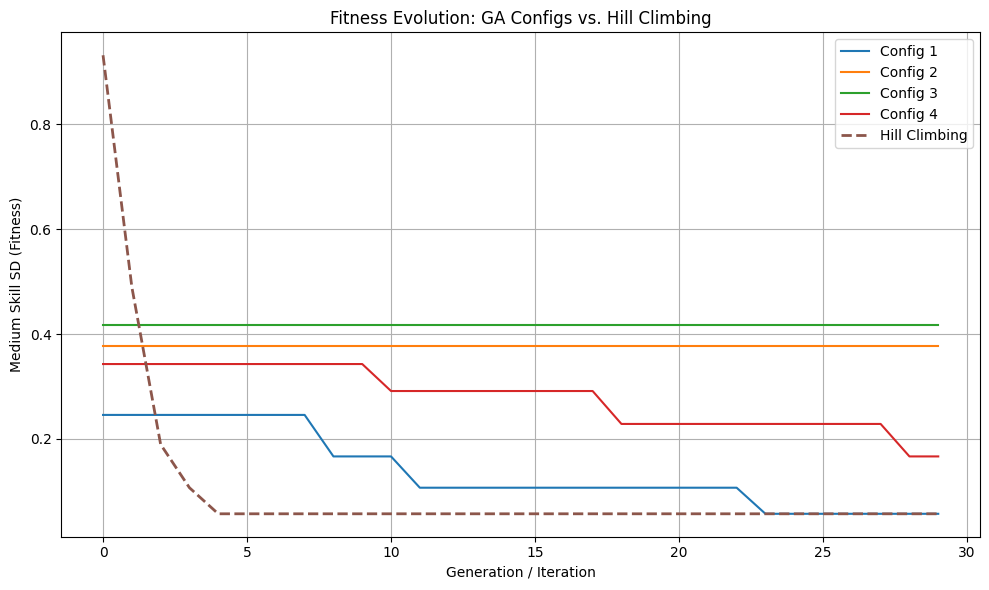

In [13]:
import matplotlib.pyplot as plt

# Plot Fitness Evolution: GA Configs vs. Hill Climbing
plt.figure(figsize=(10, 6))

# Plot each GA configuration
for label, hist in results:
    if label == "Hill Climbing":
        # Use dashed line style for hill climbing
        plt.plot(hist, label=label, linestyle='--', linewidth=2)
    else:
        plt.plot(hist, label=label)

# Deduplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicate "Hill Climbing"
plt.legend(by_label.values(), by_label.keys())

# Labeling and formatting
plt.title("Fitness Evolution: GA Configs vs. Hill Climbing")
plt.xlabel("Generation / Iteration")
plt.ylabel("Medium Skill SD (Fitness)")
plt.grid(True)
plt.tight_layout()
plt.show()


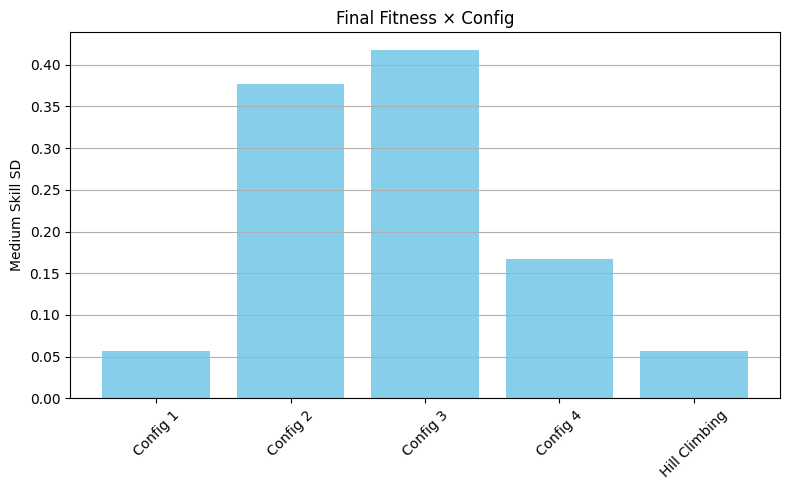

In [14]:
# Fitness configuration bar plot
labels = [label for label, _, _ in best_solutions]
fitness_values = [fit if isinstance(fit, float) else fit[-1] for _, _, fit in best_solutions]

plt.figure(figsize=(8, 5))
plt.bar(labels, fitness_values, color='skyblue')
plt.title("Final Fitness × Config")
plt.ylabel("Medium Skill SD")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [15]:
best_overall = min(best_solutions, key=lambda x: x[2] if isinstance(x[2], float) else x[2][-1])
fitness_value = best_overall[2] if isinstance(best_overall[2], float) else best_overall[2][-1]
print(f"Best Config: {best_overall[0]} | Fitness: {fitness_value:.4f}")


Best Config: Config 1 | Fitness: 0.0571


In [16]:
import pandas as pd

# Extract performance metrics
summary_data = []
for label, solution, fitness in best_solutions:
    fitness_value = fitness if isinstance(fitness, float) else fitness[-1]
    iterations = len(fitness) if isinstance(fitness, list) else len(results[0][1])
    summary_data.append({
        "Method": label,
        "Final Fitness (SD)": round(fitness_value, 4),
        "Iterations": iterations
    })

# If you tracked time, include it like this (example):
# summary_data[i]["Processing Time (s)"] = time_spent

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)
print(summary_df)


          Method  Final Fitness (SD)  Iterations
0       Config 1              0.0571          30
1       Config 2              0.3769          30
2       Config 3              0.4180          30
3       Config 4              0.1666          30
4  Hill Climbing              0.0571           5


In [36]:
# Find the best solution (lowest fitness)
best = min(best_solutions, key=lambda x: x[2] if isinstance(x[2], float) else x[2][-1])
fitness_value = best[2] if isinstance(best[2], float) else best[2][-1]

print(f"\n Best Config: {best[0]} | Fitness: {fitness_value:.4f}")

# Reconstruct team assignments
teams = [[] for _ in range(5)]  # 5 teams

# Fill each team with player details
for idx, team_id in enumerate(best[1].assignment):
    player = players[idx]
    teams[team_id].append((
        player["Name"],
        player["Position"],
        player["Skill"],
        player["Salary"]
    ))

# Display teams
for i, team in enumerate(teams):
    print(f"\n Team {i+1}:")
    for p in team:
        print(f"  {p[0]:20s} | {p[1]:3s} | Skill: {p[2]} | Salary: €{p[3]}M")



 Best Config: Config 1 | Fitness: 0.0571

 Team 1:
  Alex Carter          | GK  | Skill: 85 | Salary: €90M
  Daniel Foster        | DEF | Skill: 90 | Salary: €110M
  Mason Reed           | DEF | Skill: 82 | Salary: €75M
  Connor Hayes         | MID | Skill: 89 | Salary: €105M
  Spencer Ward         | MID | Skill: 84 | Salary: €85M
  Sebastian Perry      | FWD | Skill: 95 | Salary: €150M
  Tyler Jenkins        | FWD | Skill: 80 | Salary: €70M

 Team 2:
  Blake Henderson      | GK  | Skill: 87 | Salary: €95M
  Nathan Wright        | MID | Skill: 92 | Salary: €120M
  Chase Murphy         | FWD | Skill: 86 | Salary: €95M
  Bentley Rivera       | MID | Skill: 88 | Salary: €100M
  Jaxon Griffin        | DEF | Skill: 79 | Salary: €65M
  Brayden Hughes       | DEF | Skill: 87 | Salary: €100M
  Zachary Nelson       | FWD | Skill: 86 | Salary: €92M

 Team 3:
  Jordan Smith         | GK  | Skill: 88 | Salary: €100M
  Logan Brooks         | DEF | Skill: 86 | Salary: €95M
  Austin Torres        | 